In [1]:
import os
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
import imageio

# download torch_utils/ & dnnlib/ from
# https://github.com/NVlabs/stylegan3
# download models from
# https://catalog.ngc.nvidia.com/orgs/nvidia/teams/research/models/stylegan3/files


In [2]:
with open('stylegan3-r-ffhqu-256x256.pkl', 'rb') as f:
    pack = pickle.load(f)

In [3]:
G = pack['G_ema'].cuda()

In [4]:
# latent vector generation function
def get_data(batch_size=1):
    z = torch.randn([batch_size, G.z_dim]).cuda()
    c = None
    w = G.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)
    z = z.cpu().detach().numpy().squeeze()
    w = w.cpu().detach().numpy().squeeze()
    return z, w

In [27]:
# generate & save latent vectors
root = 'data/latent'
os.makedirs(root, exist_ok=True)
for count in range(10):
    z_list = []
    w_list = []
    for i in tqdm(range(1000)):
        z, w = get_data(10)
        z_list.append(z)
        w_list.append(w)
    z_list = np.concatenate(z_list, axis=0)
    w_list = np.concatenate(w_list, axis=0)

    with open(os.path.join(root, 'latent%d.npy' % count), 'wb') as f:
        np.save(f, z_list)
        np.save(f, w_list)

100%|██████████| 1000/1000 [00:00<00:00, 1111.80it/s]


In [7]:
# load latent vectors
files = sorted(os.listdir(root))
z_list = []
w_list = []
for name in files:
    path = os.path.join(root, name)
    print(path)
    with open(path, 'rb') as f:
        z = np.load(f)
        w = np.load(f)
    z_list.append(z)
    w_list.append(w)
z_list = np.concatenate(z_list)
w_list = np.concatenate(w_list)

data/latent\latent0.npy
data/latent\latent1.npy
data/latent\latent2.npy
data/latent\latent3.npy
data/latent\latent4.npy
data/latent\latent5.npy
data/latent\latent6.npy
data/latent\latent7.npy
data/latent\latent8.npy
data/latent\latent9.npy


In [8]:
print(z_list.shape, w_list.shape)

(100000, 512) (100000, 16, 512)


In [9]:
wr = w.reshape(w.shape[0], -1)

In [10]:
pca = PCA(n_components=20)

In [11]:
pca.fit(wr)

PCA(n_components=20)

In [12]:
c = pca.components_
v = pca.explained_variance_

In [13]:
# save PCA results
root = 'data/pca'
os.makedirs(root, exist_ok=True)
with open(os.path.join(root, 'pca.npy'), 'wb') as f:
    np.save(f, c)
    np.save(f, v)

In [24]:
with open('data/pca/pca.npy', 'rb') as f:
    pca = np.load(f)
    var = np.load(f)
std = np.sqrt(v)
pca = torch.FloatTensor(pca)
pca = pca.view(-1, 16, 512).cuda()

In [14]:
# generate image from latent vector
def get_image(w):
    img = G.synthesis(w, noise_mode='const', force_fp32=True)
    image = img.cpu().detach().numpy().transpose(0, 2, 3, 1)
    image = np.clip((image + 1) / 2, 0, 1)
    image = np.uint8(image * 255).squeeze()
    return image

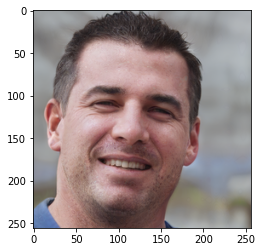

In [32]:
z = torch.randn([1, G.z_dim]).cuda()
c = None
w = G.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)
image = get_image(w)
plt.imshow(image)

In [33]:
images_total = []
for j in range(0, 20):
    com = pca[j].unsqueeze(0)
    images = []
    for i in range(-5, 6, 1):
        image = get_image(w + com * i * std[j])
        images.append(image)
    images = np.concatenate(images, 1)
    images_total.append(images)
images_total = np.concatenate(images_total, 0)
plt.figure(figsize=(32, 64))
plt.imshow(images_total)

In [26]:
imageio.imwrite('data/result.jpg', images_total)